In [1]:
import scipy.io as scio
import matplotlib.pyplot as plt

data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')

matrix_data = data['data']

print(f"\nType of 'data':", type(matrix_data))
print(f"Shape of 'data':", matrix_data.shape)


Type of 'data': <class 'numpy.ndarray'>
Shape of 'data': (16, 604700)


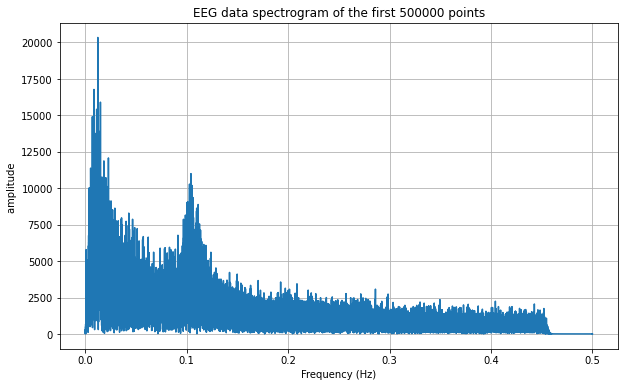

In [2]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt

# 加载数据
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']

# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]

# 对前50000个点，每10个点采样一次
sampled_data = first_channel[:500000:10]

# 使用快速傅里叶变换 (FFT) 计算频谱
frequency_spectrum = np.fft.fft(sampled_data)
frequencies = np.fft.fftfreq(len(sampled_data), d=1.0)  # d=1.0 假设采样率为1Hz，根据实际情况修改

# 绘制频谱图（只显示正频率部分）
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(frequency_spectrum[:len(frequency_spectrum)//2]))
plt.title ('EEG data spectrogram of the first 500000 points')
plt.xlabel ('Frequency (Hz)')
plt.ylabel ('amplitude ')
plt.grid(True)
plt.show()


In [20]:
sampled_data = first_channel[:50000:10]
len(sampled_data)

5000

In [19]:
len(sampled_data)

5000

从 0 Hz 开始，随着频率的增加，幅度逐渐减小。这表明该 EEG 信号在低频范围（0-0.1 Hz 左右）有较高的能量，而在高频部分能量逐渐衰减。
低频成分往往与较慢的脑电活动（例如 Delta 波或 Theta 波）相关，这些活动可能与深度睡眠或放松状态相关。低频占绝对主导地位，对应给定数据源静息态

Training progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [11:39<00:00,  3.50s/it]


均方根误差 (RMSE): 8.7807


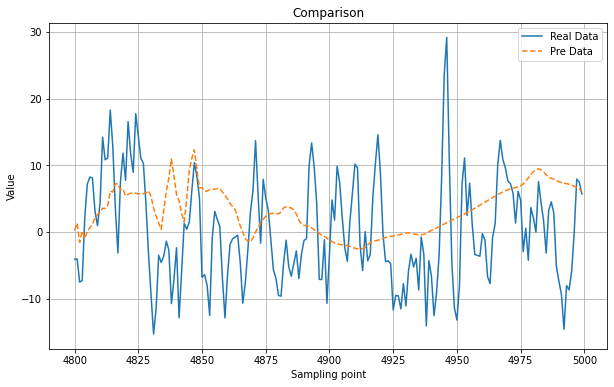

频谱相似度: 0.4910


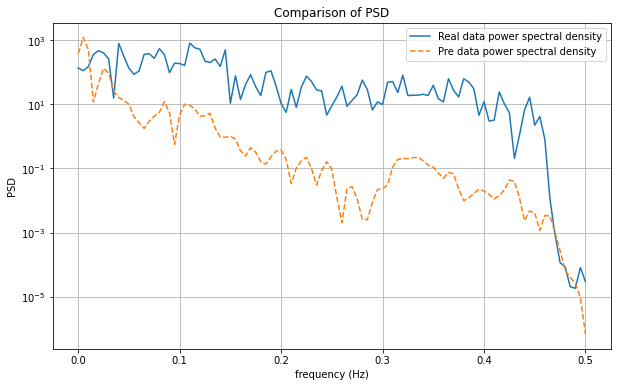

功率谱密度 (PSD) 相似度: 0.1497


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.fft import fft
from tqdm import tqdm
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.metrics import mean_squared_error

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = sampled_data[:4800]  # 前4800个点作为训练数据
test_data = sampled_data[4800:]  # 后200个点作为测试数据

n_steps = 50  # 时间步长
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, verbose=0, callbacks=[progress_callback])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 50 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0][0])
    
    # 调整 predicted 的形状，使其成为与 X_input 兼容的三维数组
    predicted_reshaped = np.array(predicted).reshape((1, 1, 1))
    
    # 使用 np.append 进行滑动窗口更新
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)  # 滑动窗口

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predicted_points))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data, label='Real Data')
plt.plot(range(4800, 5000), predicted_points, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = fft(test_data)
fft_pred = fft(predicted_points)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
similarity = cosine_similarity(fft_real_abs, fft_pred_abs)

print(f'频谱相似度: {similarity[0][0]:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [11:18<00:00,  3.39s/it]


均方根误差 (RMSE): 8.6457


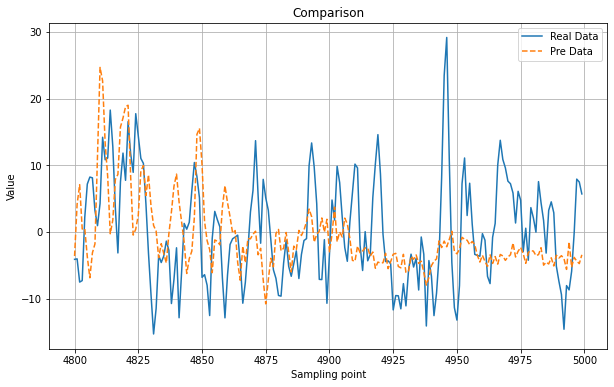

频谱相似度: 0.7545


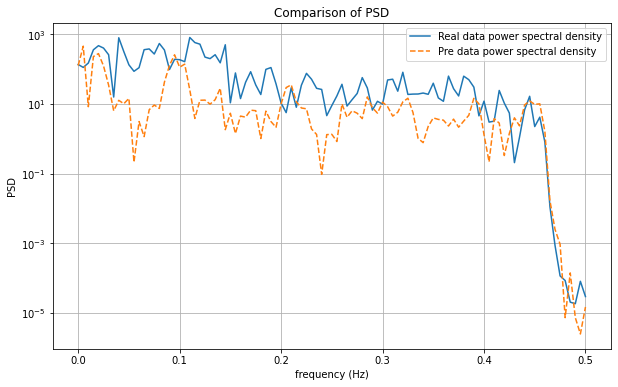

功率谱密度 (PSD) 相似度: 0.3813


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.fft import fft
from scipy.signal import welch  # 用于计算功率谱密度
from tqdm import tqdm
from tensorflow.keras.callbacks import LambdaCallback

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = sampled_data[:4800]  # 前4800个点作为训练数据
test_data = sampled_data[4800:]  # 后200个点作为测试数据

n_steps = 50  # 时间步长
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))  # 输入形状为 (时间步长, 特征数)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, verbose=0, callbacks=[progress_callback])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 50 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0][0])
    
    # 将 predicted 变成适合与 X_input 连接的三维数组
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    
    # 使用 np.append 进行滑动窗口更新
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)  # 滑动窗口，保持时间步长不变

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predicted_points))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data, label='Real Data')
plt.plot(range(4800, 5000), predicted_points, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = fft(test_data)
fft_pred = fft(predicted_points)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [10:56<00:00,  3.28s/it]


均方根误差 (RMSE): 11.8204


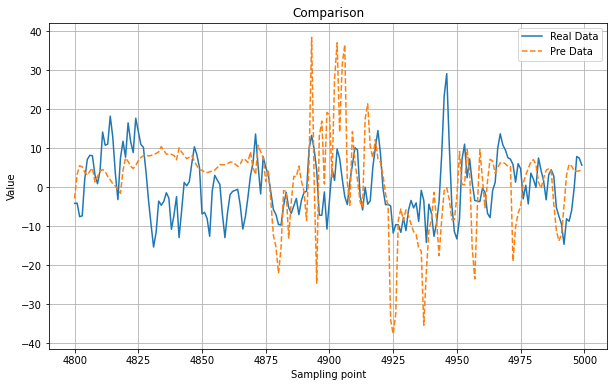

频谱相似度: 0.7825


C:\Users\Brilliant\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


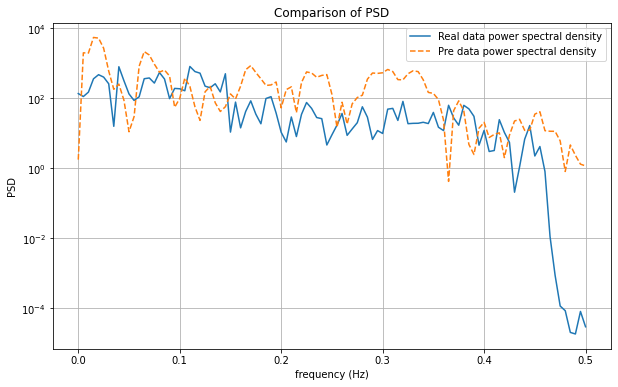

功率谱密度 (PSD) 相似度: 0.5099


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.fft import fft
from scipy.signal import welch  # 用于计算功率谱密度
from tqdm import tqdm
from tensorflow.keras.callbacks import LambdaCallback

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = sampled_data[:4800]  # 前4800个点作为训练数据
test_data = sampled_data[4800:]  # 后200个点作为测试数据

n_steps = 50  # 时间步长
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))  # 输入形状为 (时间步长, 特征数)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, verbose=0, callbacks=[progress_callback])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 50 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0][0])
    
    # 将 predicted 变成适合与 X_input 连接的三维数组
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    
    # 使用 np.append 进行滑动窗口更新
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)  # 滑动窗口，保持时间步长不变

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predicted_points))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data, label='Real Data')
plt.plot(range(4800, 5000), predicted_points, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = fft(test_data)
fft_pred = fft(predicted_points)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data, fs=1.0)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points, fs=1.0)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [10:54<00:00,  3.27s/it]


均方根误差 (RMSE): 8.0848


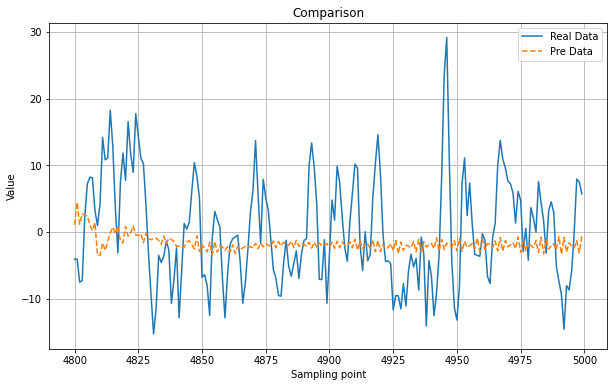

频谱相似度: 0.4058


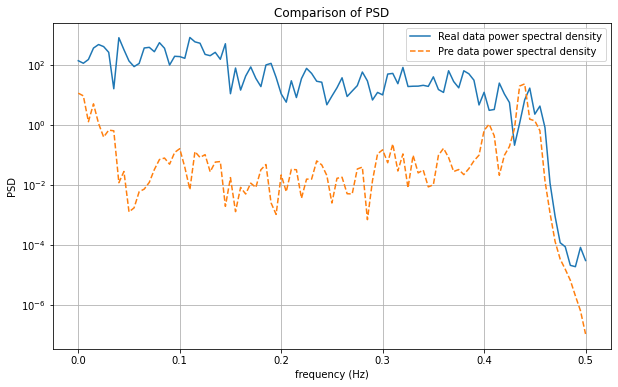

功率谱密度 (PSD) 相似度: 0.0878


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.fft import fft
from scipy.signal import welch  # 用于计算功率谱密度
from tqdm import tqdm
from tensorflow.keras.callbacks import LambdaCallback

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = sampled_data[:4800]  # 前4800个点作为训练数据
test_data = sampled_data[4800:]  # 后200个点作为测试数据

n_steps = 50  # 时间步长
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))  # 输入形状为 (时间步长, 特征数)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, verbose=0, callbacks=[progress_callback])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 50 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0][0])
    
    # 将 predicted 变成适合与 X_input 连接的三维数组
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    
    # 使用 np.append 进行滑动窗口更新
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)  # 滑动窗口，保持时间步长不变

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predicted_points))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data, label='Real Data')
plt.plot(range(4800, 5000), predicted_points, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = fft(test_data)
fft_pred = fft(predicted_points)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

loss权重中引入频谱相似度在损失函数中引入频谱误差，在训练过程中不仅考虑时域误差，还要关注频域误差。这可能有助于提高频谱相似度的稳定性。固定随机种子

预测误差会逐步累积，因为预测值依赖于前面的预测结果，所以随着预测步数的增加，预测值与真实值的差距可能会越来越大。
一次性预测多个时间步：让模型一次性输出未来多个时间步的值，而不是逐步预测。


增大 LSTM 单元的数量，例如从 50 增加到 100 或 150
加入卷积层（CNN-LSTM 混合模型）：卷积层擅长从时间序列中提取局部特征，可以在模型前面加入一层卷积层，再接 LSTM 层，这样可以增强模型对局部时域特征的提取能力，从而改善频谱特性。
增加时间步长（n_steps）
调整学习率 学习率调度器（Learning Rate Scheduler）：在训练过程中使用学习率调度器，逐渐减小学习率，可能帮助模型在训练后期更加细致地学习到频谱上的细节特征。